In [ ]:
import torch
import torchvision.datasets as ds
import torchvision.transforms as transforms

torch.cuda.is_available()

True

In [ ]:
import PIL

transforms=transforms.Compose([transforms.ToTensor(),
                              transforms.RandomHorizontalFlip(p=0.5),
                              transforms.RandomVerticalFlip(p=0.5),
                              transforms.GaussianBlur(3,(0.1,0.2)),
                              transforms.RandomRotation(45, interpolation=PIL.Image.BILINEAR)])

In [ ]:

from torch.utils.data import DataLoader
train_dataset=ds.FashionMNIST(root='./data', train=True, download=True, transform=transforms)
val_dataset=ds.FashionMNIST(root='./data', train=False, download=True, transform=transforms)

train_loader=DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
val_loader=DataLoader(dataset=val_dataset, batch_size=10, shuffle=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 16118671.75it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 268072.08it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5089462.49it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20902494.67it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
len(train_dataset)

60000

In [ ]:
len(val_dataset)

10000

**Visualize the Data**

In [ ]:
dataiter=iter(train_loader)
images, labels=next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([50, 1, 28, 28])
torch.Size([50])


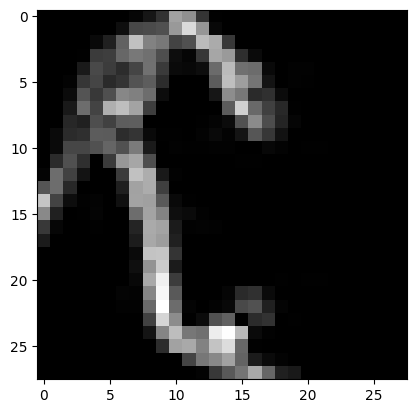

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(images[8].numpy().squeeze(), cmap='gray')

In [ ]:
import torch.nn as nn

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.cnn_layers=nn.Sequential(

        #First Block
        nn.Conv2d(1,4,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        #Second Block
        nn.Conv2d(4,4,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.linear=nn.Sequential(
        nn.Linear(4*7*7,10)
    )

  def forward(self, x):
    x=self.cnn_layers(x)
    x=x.view(x.size(0),-1)
    x=self.linear(x)
    return x


In [ ]:
device=torch.device('cuda:0')
model=Net()
model.to(device)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)

In [ ]:
#criterion loss or cost
criterion=nn.CrossEntropyLoss()


In [ ]:
#optimizer
import torch.optim as optim
optimizer=optim.Adam(model.parameters(), lr=0.001)


In [ ]:
#Training
loss_values=[]
epochs=10
for i in range(epochs):
  running_loss=0
  for images, labales in train_loader:
    images, labels=images.to(device), labels.to(device)
    optimizer.zero_grad()
    output=model(images)
    loss=criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
  print('Epoch {}-Training Loss: {:.4f}'.format(i+1, running_loss/len(train_loader)))
  loss_values.append(running_loss/len(train_loader))


Epoch 1-Training Loss: 2.2444
Epoch 2-Training Loss: 2.2439
Epoch 3-Training Loss: 2.2435
Epoch 4-Training Loss: 2.2436
Epoch 5-Training Loss: 2.2435
Epoch 6-Training Loss: 2.2436
Epoch 7-Training Loss: 2.2435
Epoch 8-Training Loss: 2.2435
Epoch 9-Training Loss: 2.2435
Epoch 10-Training Loss: 2.2433


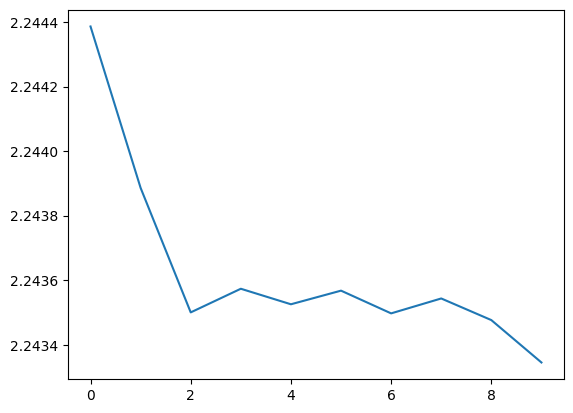

In [ ]:
plt.plot(loss_values)

In [ ]:
correct_count, all_count=0, 0

for images, labels in val_loader:
  for i in range(len(labels)):
    if torch.cuda.is_available():
      images=images.cuda()
      labels=labels.cuda()
    img=images[i].view(1,1,28,28)
    with torch.no_grad():
      logps=model(img)
    ps=torch.exp(logps)
    probab=list(ps.cpu()[0])
    pred_label=probab.index(max(probab))
    true_label=labels.cpu()[1]
    if(true_label==pred_label):
      correct_count+=1
    all_count+=1

print("Number of Images test", all_count)
print("Model Accuracy:", correct_count/all_count)

Number of Images test 10000
Model Accuracy: 0.1145
